In [ ]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import  StandardScaler, QuantileTransformer
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading the data
train_df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tasks/first task/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Preprocessing
### Exploratory Data Analysis and Feature Engineering

In [ ]:
#checking the shape of the data
train_df.shape

(891, 12)

In [ ]:
#checking for null/missing values
train_df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


#### Ticket & Cabin & PassengerId

In [ ]:
#dropping column
df=train_df.drop(['PassengerId', 'Cabin', 'Ticket'], axis=1)

In [ ]:
#removing records with null values
df=df.dropna()

#### Name

In [ ]:
#Creating a new feature('Title')
df["Title"] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

df.drop(['Name'], axis=1, inplace=True)

df["Title"].value_counts()

,count
Title,
Mr,398
Miss,145
Mrs,107
Master,36
Rev,6
Dr,6
Mlle,2
Major,2
Col,2


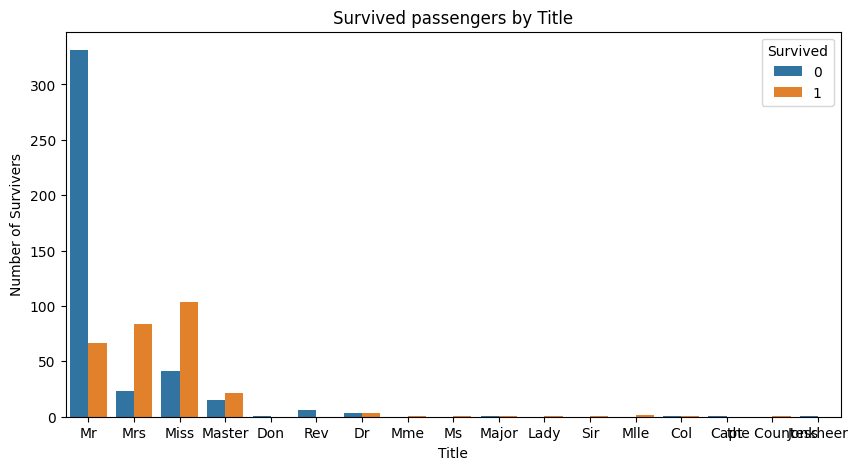

In [ ]:
#plotting number of survivors by title
plt.figure(figsize=(10, 5))
sns.countplot(x='Title', hue='Survived', data=df)
plt.title('Survived passengers by Title')
plt.xlabel('Title')
plt.ylabel('Number of Survivers')
plt.legend(title='Survived')
plt.show()

In [ ]:
#checking the survival percentage based on each title
title_survival_rate = df.groupby('Title')['Survived'].mean().sort_values()
title_survival_rate

,Survived
Title,
Capt,0.000000
Don,0.000000
Jonkheer,0.000000
Rev,0.000000
Mr,0.168342
Col,0.500000
Dr,0.500000
Major,0.500000
Master,0.583333


In [ ]:
#Creating a new feature('TitleCategory')
def map_title_by_survival(title):
    if 0.5 >= title_survival_rate[title] > 0.3:
        return '1'
    elif title_survival_rate[title] > 0.5:
        return '2'
    else:
        return '3'

df['TitleCategory'] = df['Title'].apply(map_title_by_survival)

df.drop(['Title'], axis=1, inplace=True)

df['TitleCategory']

,TitleCategory
0,3
1,2
2,2
3,2
4,3
...,...
885,2
886,3
887,2
889,3


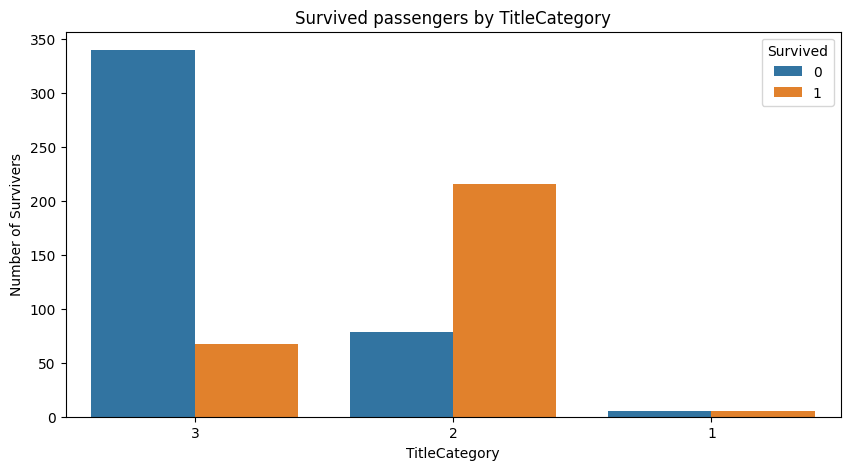

In [ ]:
#plotting number of survivors by titlecategory
plt.figure(figsize=(10, 5))
sns.countplot(x='TitleCategory', hue='Survived', data=df)
plt.title('Survived passengers by TitleCategory')
plt.xlabel('TitleCategory')
plt.ylabel('Number of Survivers')
plt.legend(title='Survived')
plt.show()

In [ ]:
# changing Pclass to object in order to apply one hot encoding to avoid ordinal relationship
df['Pclass']= df['Pclass'].astype('object')

In [ ]:
#encoding data using the get_dummies method
df_dummies=pd.get_dummies(df, drop_first=True)

In [ ]:
df_dummies.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,TitleCategory_2,TitleCategory_3
0,0,22.0,1,0,7.2500,False,True,True,False,True,False,True
1,1,38.0,1,0,71.2833,False,False,False,False,False,True,False
2,1,26.0,0,0,7.9250,False,True,False,False,True,True,False
3,1,35.0,1,0,53.1000,False,False,False,False,True,True,False
4,0,35.0,0,0,8.0500,False,True,True,False,True,False,True


In [ ]:
#Creating a new feature('AdultMale')
df_dummies['AdultMale']= ((df_dummies['Age']>=18) & (df_dummies['Sex_male'] == True))
df_dummies.groupby('Survived')['AdultMale'].sum()

,AdultMale
Survived,
0,325
1,70


In [ ]:
#checking the correlation of the adult male with survived
df_dummies['AdultMale'].corr(df_dummies['Survived'])

-0.5169272362545958

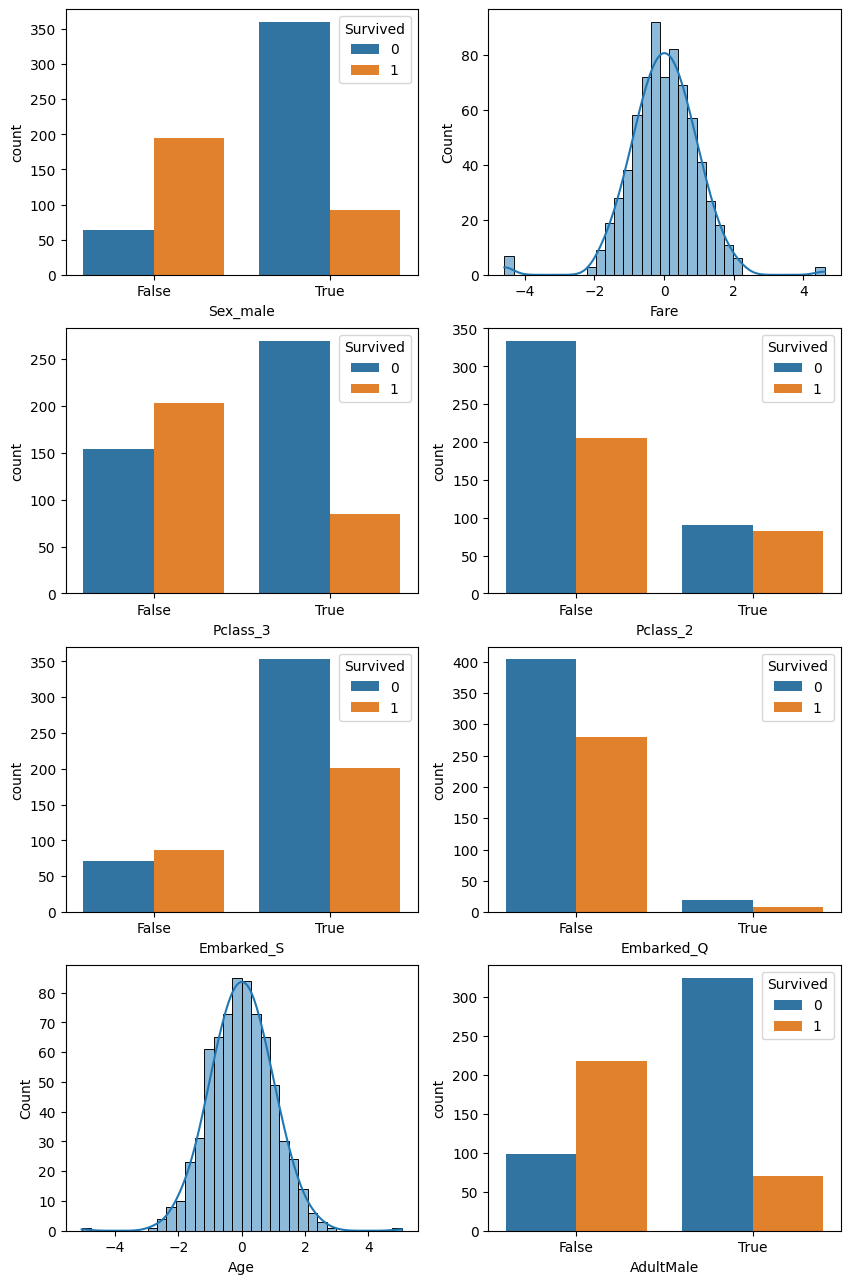

In [ ]:
plt.figure(figsize=(10, 20))
plt.subplot(5,2,1)
sns.countplot(x= df_dummies['Sex_male'], hue="Survived", data=df_dummies)
plt.subplot(5,2,2)
sns.histplot(df_dummies['Fare'], kde=True)
plt.subplot(5,2,3)
sns.countplot(x= df_dummies['Pclass_3'], hue="Survived", data=df_dummies)
plt.subplot(5,2,4)
sns.countplot(x= df_dummies['Pclass_2'], hue="Survived", data=df_dummies)
plt.subplot(5,2,5)
sns.countplot(x= df_dummies['Embarked_S'], hue="Survived", data=df_dummies)
plt.subplot(5,2,6)
sns.countplot(x= df_dummies['Embarked_Q'], hue="Survived", data=df_dummies)
plt.subplot(5,2,7)
sns.histplot(df_dummies['Age'], kde=True)
plt.subplot(5,2,8)
sns.countplot(x= df_dummies['AdultMale'], hue="Survived", data=df_dummies)
plt.show()

#### Age & Fare

In [ ]:
#checking the skewness of age
df_dummies['Age'].skew()

0.38888061787537076

In [ ]:
#checking the Correlation of Age with other features
print("Correlation of Age with other features:")
df_dummies.corr()['Age']

Correlation of Age with other features:


,Age
Survived,-0.082446
Age,1.000000
SibSp,-0.307351
Parch,-0.187896
Fare,0.093143
Pclass_2,0.009214
Pclass_3,-0.309944
Sex_male,0.099037
Embarked_Q,-0.021693
Embarked_S,-0.025431


<Axes: ylabel='Age'>

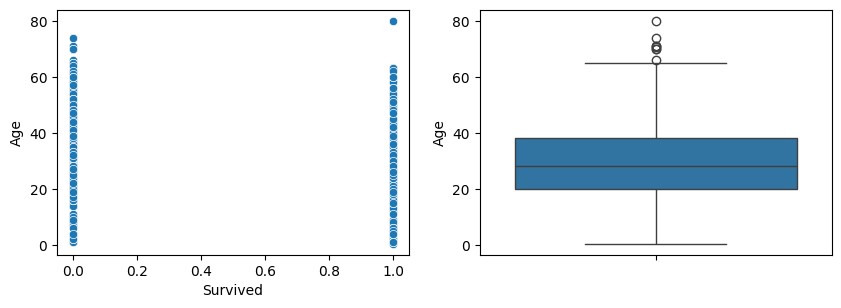

In [ ]:
#plotting graphs to check for missing values of age
plt.figure(figsize=(10, 7))
plt.subplot(2,2,1)
sns.scatterplot(x= 'Survived', y= 'Age', data= df_dummies)
plt.subplot(2,2,2)
sns.boxplot(df_dummies['Age'])

<Axes: ylabel='Fare'>

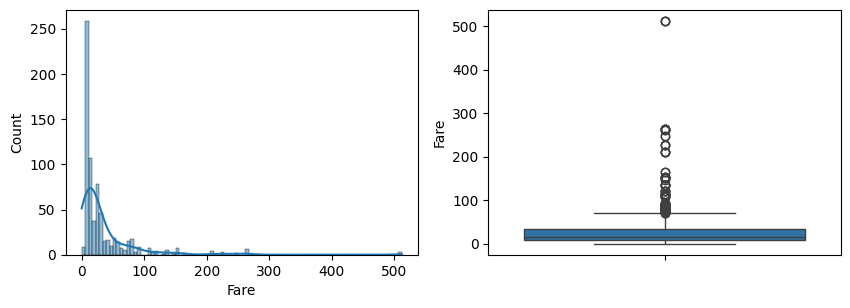

In [ ]:
#plotting graphs to check for missing values of fare
plt.figure(figsize=(10, 7))
plt.subplot(2,2,1)
sns.histplot(df_dummies['Fare'], kde=True)
plt.subplot(2,2,2)
sns.boxplot(df_dummies['Fare'])

In [ ]:
#Replacing missing values and outliers using the QuantileTransformer to reduce skewness of continuous variables
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
df_dummies[['Age', 'Fare']] = quantile_transformer.fit_transform(df_dummies[['Age', 'Fare']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (712). n_quantiles is set to n_samples.
  warnings.warn(


skewness of fare= -0.44632672322859723
skewness of age= -0.0017781231267652625


<Axes: ylabel='Age'>

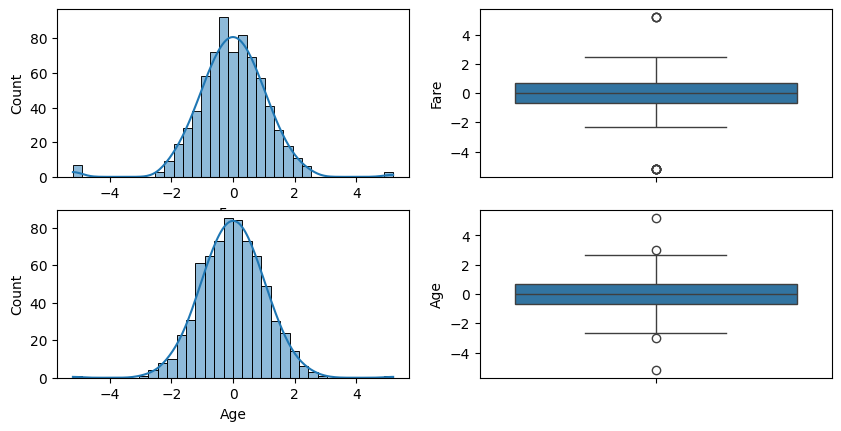

In [ ]:
print('skewness of fare=', df_dummies['Fare'].skew())
plt.figure(figsize=(10, 10))
plt.subplot(4,2,1)
sns.histplot(df_dummies['Fare'], kde=True)
plt.subplot(4,2,2)
sns.boxplot(df_dummies['Fare'])
print('skewness of age=',df_dummies['Age'].skew())
plt.subplot(4,2,3)
sns.histplot(df_dummies['Age'], kde=True)
plt.subplot(4,2,4)
sns.boxplot(df_dummies['Age'])

In [ ]:
#final normalizing for continuous variables
numeric_features = ['Age', 'Fare', 'Parch', 'SibSp']
scaler = StandardScaler()
df_dummies[numeric_features] = scaler.fit_transform(df_dummies[numeric_features])

In [ ]:
#descriptive statistics
df_dummies.describe().round(2)

,Survived,Age,SibSp,Parch,Fare
count,712.00,712.00,712.00,712.00,712.00
mean,0.40,0.00,-0.00,0.00,0.00
std,0.49,1.00,1.00,1.00,1.00
min,0.00,-5.06,-0.55,-0.51,-4.59
25%,0.00,-0.69,-0.55,-0.51,-0.59
50%,0.00,-0.02,-0.55,-0.51,0.01
75%,1.00,0.65,0.52,0.66,0.61
max,1.00,5.06,4.82,6.52,4.61


In [ ]:
df_dummies.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,TitleCategory_2,TitleCategory_3,AdultMale
0,0,-0.497235,0.522511,-0.506787,-1.285255,False,True,True,False,True,False,True,True
1,1,0.645386,0.522511,-0.506787,1.012595,False,False,False,False,False,True,False,False
2,1,-0.159644,-0.552714,-0.506787,-0.690404,False,True,False,False,True,True,False,False
3,1,0.469419,0.522511,-0.506787,0.852161,False,False,False,False,True,True,False,False
4,0,0.469419,-0.552714,-0.506787,-0.591944,False,True,True,False,True,False,True,True


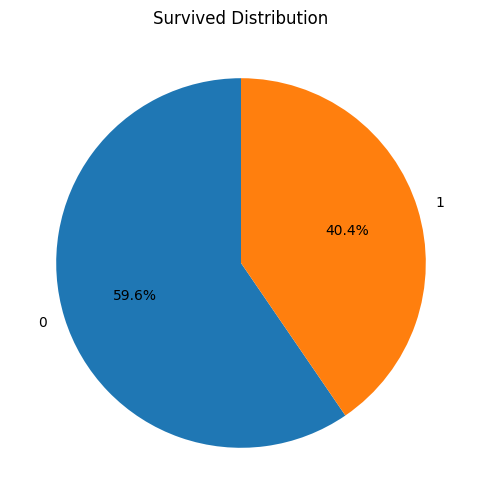

In [ ]:
#pie chart
plt.figure(figsize=(10,6))
plt.pie(df['Survived'].value_counts(), labels=[0, 1], autopct='%1.1f%%', startangle=90)
plt.title('Survived Distribution')
plt.show()

## Coorelation

<Axes: >

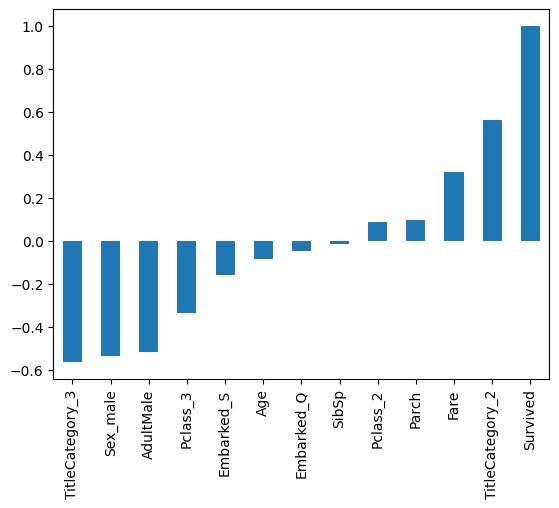

In [ ]:
df_dummies.corr()['Survived'].sort_values().plot(kind='bar')

<Axes: >

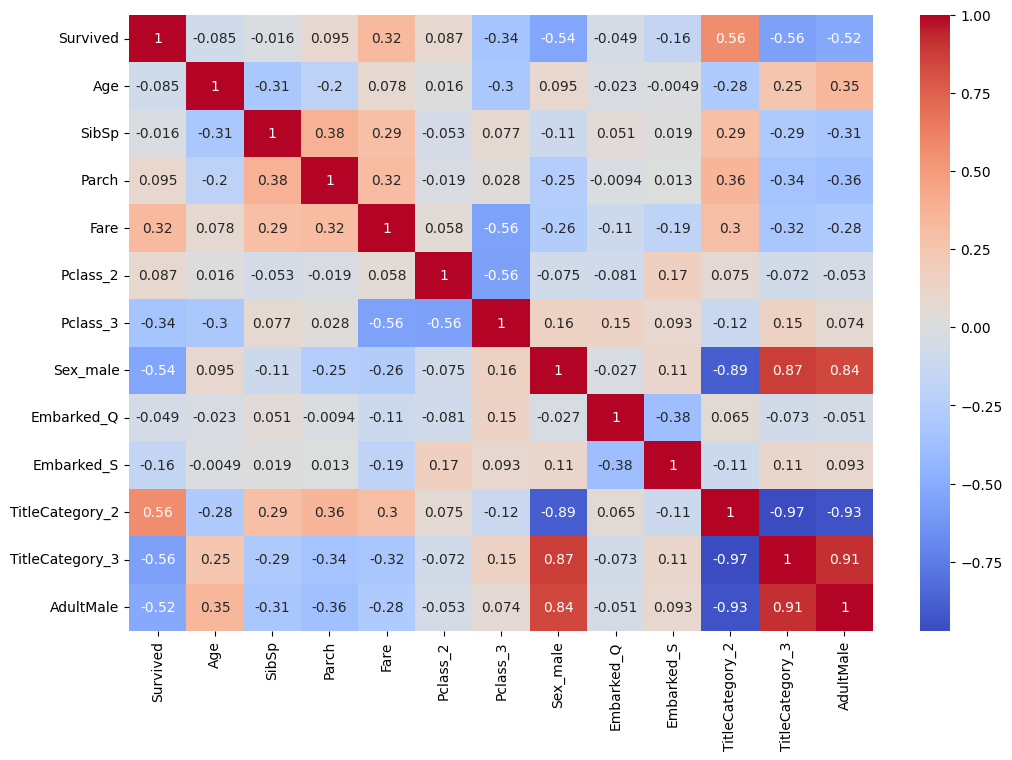

In [ ]:
#coorelation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_dummies.corr(),annot=True, cmap='coolwarm')

## Train Test Split

In [ ]:
X=df_dummies.drop(['Survived'], axis=1)
y=df_dummies['Survived']
Xtrain, Xtest, ytrain, ytest= train_test_split(X, y, test_size=0.3, random_state=13)

### Hyperparameter Tuning and Model Implementation

#### RandomForestClassifier

In [ ]:
param_grid = {'max_depth': [2, 3, 5, 6, 7],
              'max_features': [4, 6, 7, 8, 9, 10],
              'n_estimators':[30, 50,100],
              'min_samples_split': [5, 6, 7, 8, 9]
              }
RanFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, refit=True, verbose=0)
RanFor_grid.fit(Xtrain,ytrain)
best_ranf= RanFor_grid.best_estimator_


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
RanFor_grid.best_params_

{'max_depth': 3, 'max_features': 6, 'min_samples_split': 8, 'n_estimators': 50}

In [ ]:
best_ranf.fit(Xtrain,ytrain)
ypred_ranf1=best_ranf.predict(Xtest)

In [ ]:
print("Random Forest:\naccuracy:   ", accuracy_score(ytest, ypred_ranf1))
print("accuracy train:   ", accuracy_score(ytrain, model.predict(Xtrain)))
print("cross validation score:   ", RanFor_grid.best_score_)
print(classification_report(ytest, ypred_ranf1))
print("Confusion Matrix:\n", confusion_matrix(ytest, ypred_ranf1))

Random Forest:
accuracy:    0.8551401869158879
accuracy train:    0.9899598393574297
cross validation score:    0.8132121212121213
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       129
           1       0.84      0.79      0.81        85

    accuracy                           0.86       214
   macro avg       0.85      0.84      0.85       214
weighted avg       0.85      0.86      0.85       214

Confusion Matrix:
 [[116  13]
 [ 18  67]]


#### XGBClassifier

In [ ]:
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
}
xgb_model= GridSearchCV(XGBClassifier(), param_grid, cv=5, verbose=0)
xgb_model.fit(Xtrain, ytrain)
best_model=xgb_model.best_estimator_
xgb_model.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 200,
 'reg_alpha': 0,
 'subsample': 1.0}

In [ ]:
best_model.fit(Xtrain,ytrain)
ypred_xgb=best_model.predict(Xtest)

In [ ]:
print("XGBosst:\naccuracy:   ", accuracy_score(ytest, ypred_xgb))
print("accuracy train:   ", accuracy_score(ytrain, best_model.predict(Xtrain)))
print("cross validation score:   ", xgb_model.best_score_)
print(classification_report(ytest, ypred_xgb))
print("Confusion Matrix:\n", confusion_matrix(ytest, ypred_xgb))

XGBosst:
accuracy:    0.8785046728971962
accuracy train:    0.8433734939759037
cross validation score:    0.8071515151515152
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       129
           1       0.86      0.84      0.85        85

    accuracy                           0.88       214
   macro avg       0.87      0.87      0.87       214
weighted avg       0.88      0.88      0.88       214

Confusion Matrix:
 [[117  12]
 [ 14  71]]


#### LogisticRegression

In [ ]:
param_grid= {'C': [0.01, 0.1, 1, 10, 100],
             'penalty': ['l2'],
             'solver': ['liblinear', 'saga'],
             'max_iter': [100, 200, 300],
             'fit_intercept': [True, False],
             'tol': [0.0001, 0.00001]
             }
log_Grid= GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring= 'accuracy', n_jobs=-1, verbose=0)
log_Grid.fit(Xtrain,ytrain)
best_log_reg= log_Grid.best_estimator_
log_Grid.best_params_

{'C': 10,
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'liblinear',
 'tol': 0.0001}

In [ ]:
best_log_reg.fit(Xtrain,ytrain)
ypred_log=best_log_reg.predict(Xtest)

In [ ]:
print("Logistic Regression:\ntest accuracy:   ", accuracy_score(ytest, ypred_log))
print("train accuracy :   ", accuracy_score(ytrain, best_log_reg.predict(Xtrain)))
print("cross validation score:   ", log_Grid.best_score_)
print(classification_report(ytest, ypred_log))
print("Confusion Matrix:\n", confusion_matrix(ytest, ypred_log))

Logistic Regression:
test accuracy:    0.8644859813084113
train accuracy :    0.8172690763052208
cross validation score:    0.8074285714285715
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       129
           1       0.83      0.82      0.83        85

    accuracy                           0.86       214
   macro avg       0.86      0.86      0.86       214
weighted avg       0.86      0.86      0.86       214

Confusion Matrix:
 [[115  14]
 [ 15  70]]


#### DecisionTreeClassifier

In [ ]:
dtree = DecisionTreeClassifier()

param_grid = {
    'max_depth': [2,4,6,8,10,16,20],
    'min_samples_leaf': [1,2,3,4,5,8,10],
    'criterion': ['gini', 'entropy']
    }

grid_dtree = GridSearchCV(estimator=dtree, param_grid=param_grid, cv = 10, scoring = 'accuracy', n_jobs = 1, verbose = 1)

grid_dtree.fit(Xtrain, ytrain)
grid_dtree.best_params_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}
Best Cross-Validation Score: 0.81
Test Accuracy: 0.86


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
dtree_model = grid_dtree.best_estimator_
Ypred_dtree = dtree_model.predict(Xtest)

In [ ]:
print("Decision Tree:\ntest accuracy:   ", accuracy_score(ytest, Ypred_dtree))
print("train accuracy :   ", accuracy_score(ytrain, dtree_model.predict(Xtrain)))
print("cross validation score:   ", grid_dtree.best_score_)
print(classification_report(ytest, Ypred_dtree))
print("Confusion Matrix:\n", confusion_matrix(ytest, Ypred_dtree))

Decision Tree:
test accuracy:    0.8551401869158879
train accuracy :    0.8393574297188755
cross validation score:    0.8051836734693879
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       129
           1       0.83      0.80      0.81        85

    accuracy                           0.86       214
   macro avg       0.85      0.85      0.85       214
weighted avg       0.85      0.86      0.85       214

Confusion Matrix:
 [[115  14]
 [ 17  68]]


### StackingClassifier

In [ ]:
#using stackingclassifier to improve accuracy and reduce error
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42, max_depth=7, max_features=4, min_samples_split=9)),
    ('dt', DecisionTreeClassifier(max_depth=5, criterion='gini', min_samples_leaf=1, random_state=42)),
    ('xgb', XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=200, reg_alpha=0.1, subsample=0.7, random_state=42))
]

meta_model = LogisticRegression(C=10, fit_intercept=True, max_iter=100, penalty='l2', solver='saga', tol=0.0001)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=10)
stacking_model.fit(Xtrain, ytrain)

Ypred_stacking = stacking_model.predict(Xtest)
accuracy = accuracy_score(ytest, Ypred_stacking)
print(f"Stacking Test Accuracy: {accuracy}")
print("Stacking Train Accuracy:", accuracy_score(ytrain, stacking_model.predict(Xtrain)))

Stacking Test Accuracy: 0.9018691588785047
Stacking Train Accuracy: 0.8815261044176707


In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(stacking_model, Xtrain, ytrain, cv=10, scoring='accuracy')

# Output the results
print("Cross-Validation Scores: ", cv_scores)
print("Mean Cross-Validation Score: ", np.mean(cv_scores))

Cross-Validation Scores:  [0.78       0.66       0.88       0.9        0.8        0.8
 0.8        0.72       0.79591837 0.81632653]
Mean Cross-Validation Score:  0.7952244897959184


#### Classification Report

In [ ]:
print(classification_report(ytest, Ypred_stacking))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       129
           1       0.92      0.82      0.87        85

    accuracy                           0.90       214
   macro avg       0.91      0.89      0.90       214
weighted avg       0.90      0.90      0.90       214



#### Confusion Matrix Heatmap

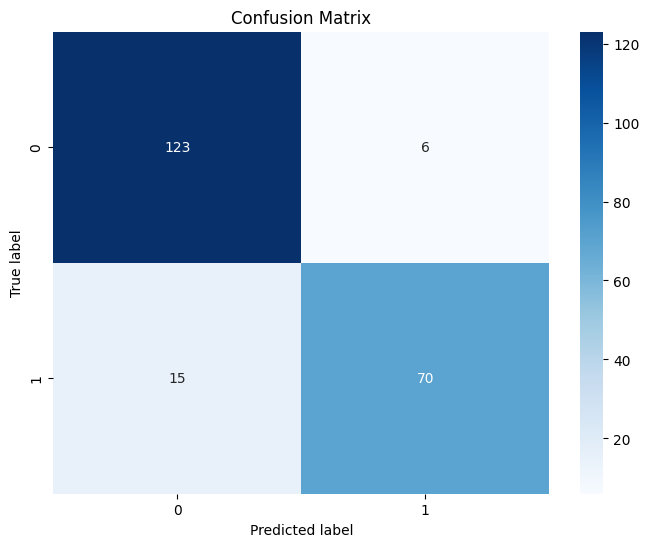

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(ytest, Ypred_stacking), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()